# Analyzing NYC High School Data

# Introduction

The SAT (Schoolastic Aptitude Test) is administered during the senior year of high school. Colleges across the country rely on SAT scores as one of their key admission critera.

We will use data published by the New York City Public schools in order to investigate some of these questions and explore some of the demographic factors that may be connected to variations in SAT scores. The inital dataset covers 435 highschools with over 100 pieces of information on school performance, programs and student demographics for each school.

New York City has a significant immigrant population and is very diverse, so one of the aims of this project is to find correlations between SAT scores and demographic factors such as gender, race, income and others variables. 

# Conclusions

# Prerequisites

In this project are used the following Python packages:
<li><b>Numpy</b></li>
<li><b>Pandas</b></li>    
<li><b>Seaborn</b></li>    
<li><b>Matplotlib</b></li>   
<li><b>Warnings</b></li>        
<li><b>Plotly</b></li>            
<li><b>Cufflinks</b></li> 
<li><b>Sklearn</b></li>                    

# Read in the data

The final data set combines 7 different data sets freely published by New York City in order to find correlations between SAT scores, different demographic measures (for example, gender/ethnicity) or schools satisfaction scores (for example, school safety):


<li> <b> SAT scores by school:</b> SAT scores for each high school in New York City.</li>
<li> <b> School attendance:</b> Attendance information for each school in New York City.</li>
<li> <b> School survey:</b> Surveys of parents, teachers, and students at each school.</li>
<li> <b> Class size:</b> Information on class size for each school.</li>
<li> <b> AP test results:</b> Advanced Placement (AP) exam. </li>
<li> <b> Graduation outcomes:</b> he percentage of students who graduated, and other outcome information.</li>
<li> <b> Demographics:</b> Demographic information for each school.</li>

In [1]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pandas as pd
import numpy
import re
%matplotlib inline

In [2]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import cufflinks as cf

In [95]:
from sklearn import preprocessing

In [3]:
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [4]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [5]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [8]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

<AxesSubplot:>

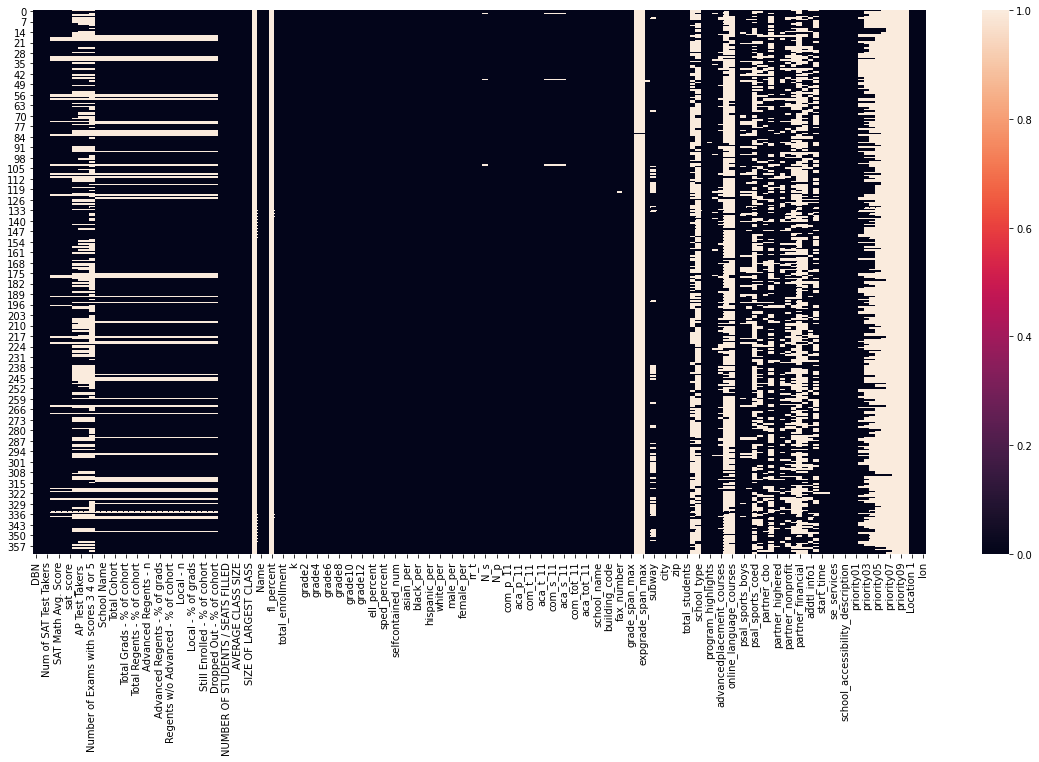

In [11]:
plt.figure(figsize=(20, 10))
sns.heatmap(combined.isnull())

In [12]:
combined.isnull().sum()

DBN                                  0
SCHOOL NAME                          0
Num of SAT Test Takers               0
SAT Critical Reading Avg. Score     28
SAT Math Avg. Score                 28
                                  ... 
priority09                         363
priority10                         363
Location 1                           0
lat                                  0
lon                                  0
Length: 159, dtype: int64

After creating the combined dataset, the previous heatmap shows us that ther are som columns like **priority09** which contain mainly null values. To solve this problem, data imputation technique will be applied. 

# Data Imputation

In [13]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


# Add a school district column for mapping

In [14]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# New York Schools sat scores distribution 

/home/radu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



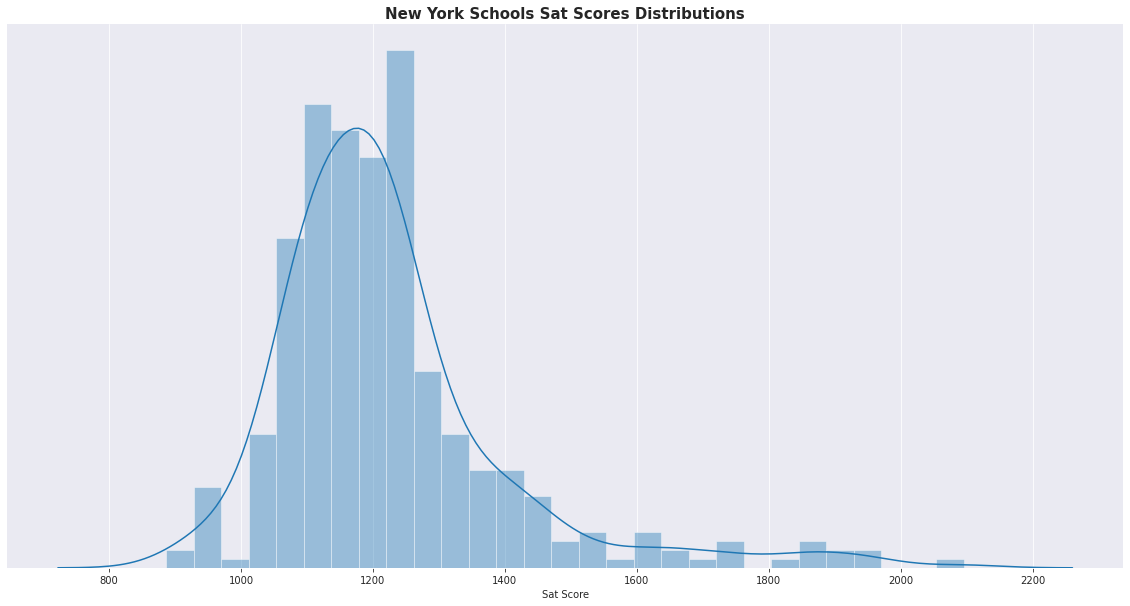

In [15]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.distplot(combined['sat_score'])
ax.set_yticks([]) 
ax.set_title("New York Schools Sat Scores Distributions", fontweight="bold", fontsize=15,)
ax.set_xlabel("Sat Score")
ax.set_ylabel("")
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
sns.despine(left=True)

The **New York Schools Sat Scores Distributions** histogram shows us that the majority of the schools have a sat score between **1100 and 1300**. There are some schools over **1600** sat score, these may be considered as schools with a high sat score.

# Find correlations

In [16]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [17]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [18]:
sns.set_style("darkgrid")

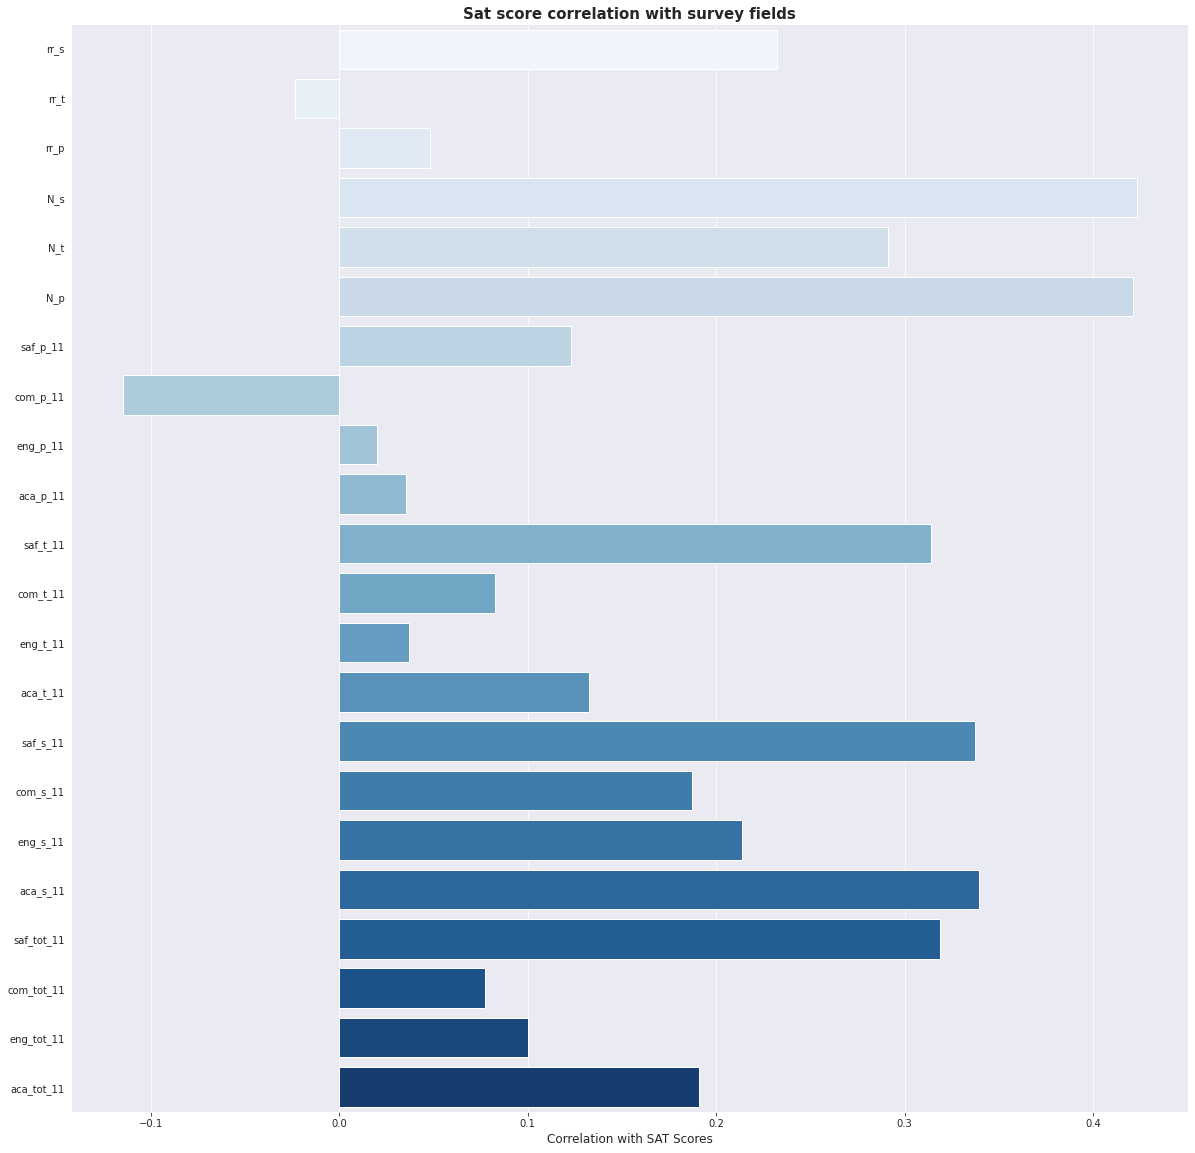

In [19]:
plt.figure(figsize=(20, 20))
ax = sns.barplot(y=survey_fields, x=correlations[survey_fields], palette='Blues')
ax.set_title("Sat score correlation with survey fields", fontweight="bold", fontsize=15,)
ax.set_xlabel("Correlation with SAT Scores",fontsize=12)
ax.set_ylabel("",fontsize=14)
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
sns.despine(left=True)

As is shown in the previous **Sat score correlation with survey fields** plot. There are high correlations between **sat_score** and **N_s and N_p**. It makes sense, since these columns are correlated with the **total_enrollment** column.

Follwed by the safety columns **saf_t_11 and saf_s_11** which are high correlated with the **sat_score** column to.

Also, another interesting correlation but no with the same importance as the previous ones is the **sat_score** correlation with **rr_s** colum. Which shows the student response rate.

# Differences between parent, teacher and students responses

In [20]:
df = combined[['DBN'] + survey_fields]
df

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M292,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,...,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,01M448,84.0,95,10,385.000000,37.0,46.0,7.9,7.4,7.2,...,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,01M450,0.0,98,28,598.208333,42.0,150.0,8.7,8.2,8.1,...,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,01M509,90.0,100,21,306.000000,29.0,69.0,7.7,7.4,7.2,...,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,01M539,98.0,68,51,923.000000,67.0,736.0,8.5,7.9,7.9,...,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,32K545,80.0,57,34,504.000000,28.0,205.0,8.0,7.5,7.5,...,3.4,4.8,6.400000,5.800000,6.200000,7.000000,6.7,5.2,5.7,6.5
359,32K549,73.0,88,41,295.000000,30.0,160.0,8.2,8.1,7.9,...,8.1,8.5,6.500000,5.900000,6.600000,7.300000,7.3,7.2,7.5,8.1
360,32K552,59.0,49,31,256.000000,17.0,127.0,7.9,7.9,7.7,...,7.0,7.1,6.400000,5.700000,6.700000,7.300000,6.9,6.5,7.1,7.4
361,32K554,88.0,81,38,206.000000,13.0,80.0,9.4,8.6,8.5,...,9.1,9.6,8.900000,7.100000,8.400000,8.900000,9.3,8.1,8.7,9.1


In [21]:
df = df.melt(id_vars='DBN')
df

,DBN,variable,value
0,01M292,rr_s,89.0
1,01M448,rr_s,84.0
2,01M450,rr_s,0.0
3,01M509,rr_s,90.0
4,01M539,rr_s,98.0
...,...,...,...
7981,32K545,aca_tot_11,6.5
7982,32K549,aca_tot_11,8.1
7983,32K552,aca_tot_11,7.4
7984,32K554,aca_tot_11,9.1


In [22]:
aux = pd.DataFrame(df['variable'].str.split("_").to_list())
df['question'] = aux[0]
df['respondent'] = aux[1]
df = df.drop(columns=['variable'])
df

,DBN,value,question,respondent
0,01M292,89.0,rr,s
1,01M448,84.0,rr,s
2,01M450,0.0,rr,s
3,01M509,90.0,rr,s
4,01M539,98.0,rr,s
...,...,...,...,...
7981,32K545,6.5,aca,tot
7982,32K549,8.1,aca,tot
7983,32K552,7.4,aca,tot
7984,32K554,9.1,aca,tot


In [23]:
df['question'].value_counts(dropna=False)

saf    1452
eng    1452
com    1452
aca    1452
rr     1089
N      1089
Name: question, dtype: int64

In [24]:
df['respondent'].value_counts(dropna=False)

s      2178
p      2178
t      2178
tot    1452
Name: respondent, dtype: int64

In [25]:
df = df[df['respondent'] != 'tot']
df = df[df['question'] != 'N']
df = df[df['question'] != 'rr']
df['respondent'] = df['respondent'].map({
    'p': 'Parent', 
    't':'Teacher', 
    's':'Student'})
df['question'] = df['question'].map({
    'aca': 'Academic Expectations', 
    'eng': 'Engagement', 
    'com': 'Communication',
    'saf': 'Safety'})
df = df.reset_index(drop=True)
df

,DBN,value,question,respondent
0,01M292,7.8,Safety,Parent
1,01M448,7.9,Safety,Parent
2,01M450,8.7,Safety,Parent
3,01M509,7.7,Safety,Parent
4,01M539,8.5,Safety,Parent
...,...,...,...,...
4351,32K545,7.0,Academic Expectations,Student
4352,32K549,7.3,Academic Expectations,Student
4353,32K552,7.3,Academic Expectations,Student
4354,32K554,8.9,Academic Expectations,Student


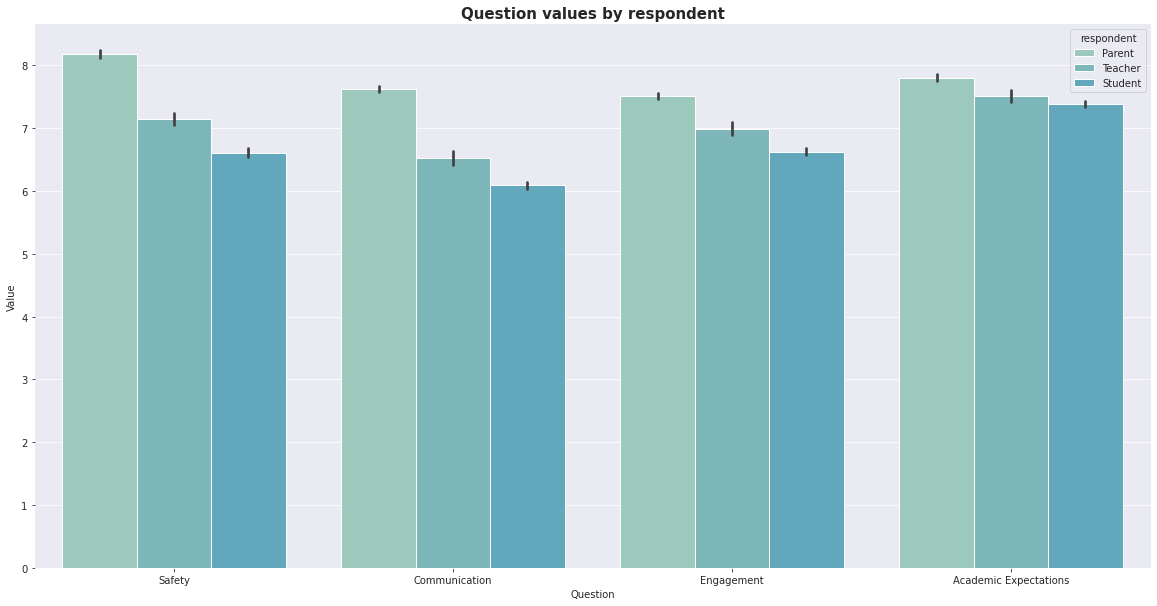

In [26]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.barplot(x='question',
                 y='value',
                 hue='respondent',
                 data=df,
                 palette=sns.color_palette("GnBu_d"))
ax.set_title("Question values by respondent", fontweight="bold", fontsize=15,)
ax.set_xlabel("Question")
ax.set_ylabel("Value")
ax.tick_params(bottom=True, top=False, left=True, right=False, labelbottom=True)
sns.despine(left=True)

From the **Question values by respondent** chart, we can see that all perceptions independently of the role of the participant are common. In general students are the ones that rate things slightly lower than teachers and parents. On the other hand, parents are the ones who rate things slightly higher. Teachers are in the middle quite near the student's ratings.

The only type of question where students and parents ratings are quite the same is **Academic Expectations**.

On the other hand, **Safety** rating seems to be the aspect where they differ the most. That's why in the next section the **Safety scores** will be deeply explored.

# Exploring safety scores

In [27]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='saf_s_11',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["saf_s_11"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='Safety score 11',
    yTitle='Satisfaction score avg',
    title='Exploring safety score'
)

After seeing the **Exploring safety score** we can conclude that there is a correlation between the **sat_score** and **sad_s_11**.

The majority of the schools have an average **saf_s_11** between **5.5 and 7.5** and an average **sat_score** over **1000** and **1400**.

Also, we can see that there is a high correlation between schools with an extremely high SAT score and **sad_s_11** score.

To sum up, there is a correlation between these indicators but it isn't so strong at may seem at first look.

In [28]:
fig = px.scatter(combined[['sat_score','SCHOOL NAME', 'saf_tot_11', 'boro']].dropna(),
                 trendline='ols',
                 x="saf_tot_11", 
                 y="sat_score", 
                 size="saf_tot_11", 
                 color="sat_score", 
                 size_max=15, 
                 hover_name="SCHOOL NAME", 
                 hover_data=['boro', 'saf_tot_11','sat_score'],
                 color_continuous_scale=px.colors.sequential.Viridis, 
                 title='Environment Safety and Respect Perception Correlation with SAT Scores')
fig.show()

In the **Environment Safety and Respect Perception Correlation with SAT Scores** plot we can see clearly the postivie correlation between **sad_tot_11** and **sat_scores** with the number of outliers in the upper-right corner. 

On the other hand, the previous plot also shows us that there is a reduced group of schools which have a high safety rank but low SAT scores. In the lower right part of the chart, this schools are mainly from **Queens and Brooklyn**.

## Mapping safety scores

In [29]:
safety_avg_by_district = combined.groupby('school_dist').agg(numpy.mean)
safety_avg_by_district

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,139.041709,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,97.597416,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,129.765099,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,100.118588,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240


In [30]:
safety_avg_by_district.reset_index(inplace=True)

In [34]:
import folium
import branca.colormap as cm

In [35]:
# NY = [40.693943, -73.985880]
school_map = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=10,
                        tiles='CartoDB positron')

map_title = "Safety average by district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

size_parameter = "total_enrollment"
color_parameter = "saf_s_11"


start_col_val = safety_avg_by_district[color_parameter].min()
end_col_val = safety_avg_by_district[color_parameter].max()
start_col_hex = "#d01c8b" # used https://colorbrewer2.org/ 
end_col_hex = "#4dac26"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     #"white",
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety average by district"

for index, row in safety_avg_by_district.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)

school_map.add_child(colormap)
    

school_map

In [36]:
saf_pivot_df = combined.pivot_table(index=['boro', 'school_dist'], values='saf_s_11', margins='All')
index = saf_pivot_df.index
saf_pivot_df

saf_s_11
boro          school_dist          
Bronx         07           6.800000
              08           6.364697
              09           6.655000
              10           6.577273
              11           6.186667
              12           7.116667
Brooklyn      13           6.407692
              14           6.685714
              15           6.177778
              16           5.875000
              17           6.007143
              18           6.190909
              19           6.150000
              20           7.120000
              21           6.390909
              22           7.025000
              23           6.233333
              32           6.766667
Manhattan     01           6.768611
              02           6.910660
              03           6.716667
              04           6.885714
              05           6.314286
              06           6.950000
Queens        24           7.107692
              25           6.912500
              26           6.760000
              27           6.390000
              28           6.627273
              29           6.075000
              30           7.033333
Staten Island 31           6.530000
All                        6.611667

In [37]:
saf_pivot_df = saf_pivot_df.reset_index(drop=True)

In [38]:
df = pd.DataFrame(index.tolist())
df['saf_s_11'] = saf_pivot_df['saf_s_11']

In [39]:
df

,0,1,saf_s_11
0,Bronx,07,6.800000
1,Bronx,08,6.364697
2,Bronx,09,6.655000
3,Bronx,10,6.577273
4,Bronx,11,6.186667
5,Bronx,12,7.116667
6,Brooklyn,13,6.407692
7,Brooklyn,14,6.685714
8,Brooklyn,15,6.177778
9,Brooklyn,16,5.875000


In [40]:
df = df.rename(columns={0: "boro", 1: "school_dist"})
df.drop(df.tail(1).index,inplace=True)
df

,boro,school_dist,saf_s_11
0,Bronx,07,6.800000
1,Bronx,08,6.364697
2,Bronx,09,6.655000
3,Bronx,10,6.577273
4,Bronx,11,6.186667
5,Bronx,12,7.116667
6,Brooklyn,13,6.407692
7,Brooklyn,14,6.685714
8,Brooklyn,15,6.177778
9,Brooklyn,16,5.875000


In [41]:
import plotly.express as px
fig = px.bar(df, x='school_dist', y='saf_s_11', color='boro', title='Saf_s_11 by school district')
fig.show()

From the **Safety average by district** interactive map, it looks like:
<li> High safety scores: Upper Manhattan and parts of Queens.</li>
<li> Low safety scores: Brooklyn.</li>

From the safety by district table printed and **Saf_s_11 by school district** interactive bar chart we can exctract more precise conclusions:
<li> saf_s_11 scores, range from a low of 5.87 for district 16 in Brooklyn, to a high of 7.12 for district 20, which is also in Brooklyn.</li>
<li> Queens and the Bronx have districts near both the bottom and top of the range.</li>
<li> The unique district of Staten Island's saf_s_11 score is under the mean of the city.</li>

# Racial differences in SAT preformance

In [97]:
race_percentage_indicators = [
    'white_per', 
    'asian_per', 
    'black_per', 
    'hispanic_per'
]

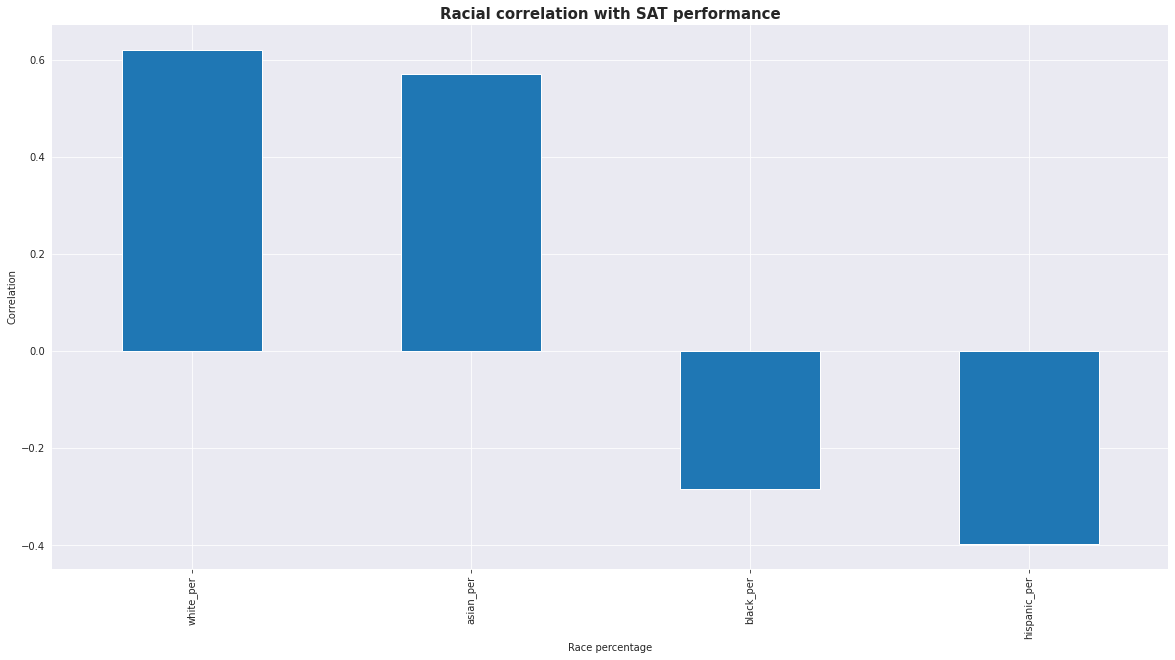

In [100]:
plt.figure(figsize=(20, 10))
ax = correlations[race_percentage_indicators].plot.bar()
ax.set_title("Racial correlation with SAT performance", fontweight="bold", fontsize=15,)
ax.set_xlabel("Race percentage")
ax.set_ylabel("Correlation")
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
sns.despine(left=True)

From the **Racial correlation with SAT performance** it seems like a higher percentage of **white** or **asian** students correlates positively with the **SAT score** averages. 

On the other hand, seems looks like a higher percentage of **black** and **hispanic** students correlates negatively with  the **SAT score** averages. 

On this point we have two questions are this correlations due a lack of funding for schools in certain areas, with higher percentage of **black** and **hispanic** students or simply **white** and **asian** students are more fitting better in the current educational system.

## Hispanic per vs Sat score

In [44]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='hispanic_per',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["hispanic_per"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='Hispanic %',
    yTitle='Satisfaction score avg',
    title='Hispanic per vs Sat score'
)

It tseems that there isn't a strong correlation between **Hispanic per and Sat score** but the previous plot shows clearly that independently of the percentage of the **hispanic** students, the  **Sat score** is between 1000 and 1400, as we have seen previously.

What the previous scatter plot shows is that the schools with a percentage of **hispanic** students between 0% and 20% are the ones with a higher average **Satisfaction score**.

On the other hand the extreme cases of the schools with a a hispanic students percentage of **100%** are the ones with lower **SAT score**. This may be due a lack of capital on this schools for **hispanic** students.

In [46]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Schools info
<a href="https://en.wikipedia.org/wiki/List_of_high_schools_in_New_York_City" > Schools info.</a> After reading the descriptions of the listed schools, they appear to primarily be geared towards recent immigrants to the US. These schools students are starting the inclusion program by  learning English, which would explain the lower SAT scores.

In [47]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above are specialized on science and technology, that generally receive extra founding to foment investigation and research. They only admin students after passing an entrance exam. 

There is no explanation why this percentage of hispanic students is so low, but the admision process may explain why the SAT score of this students is higher.

# Gender differences in SAT scores

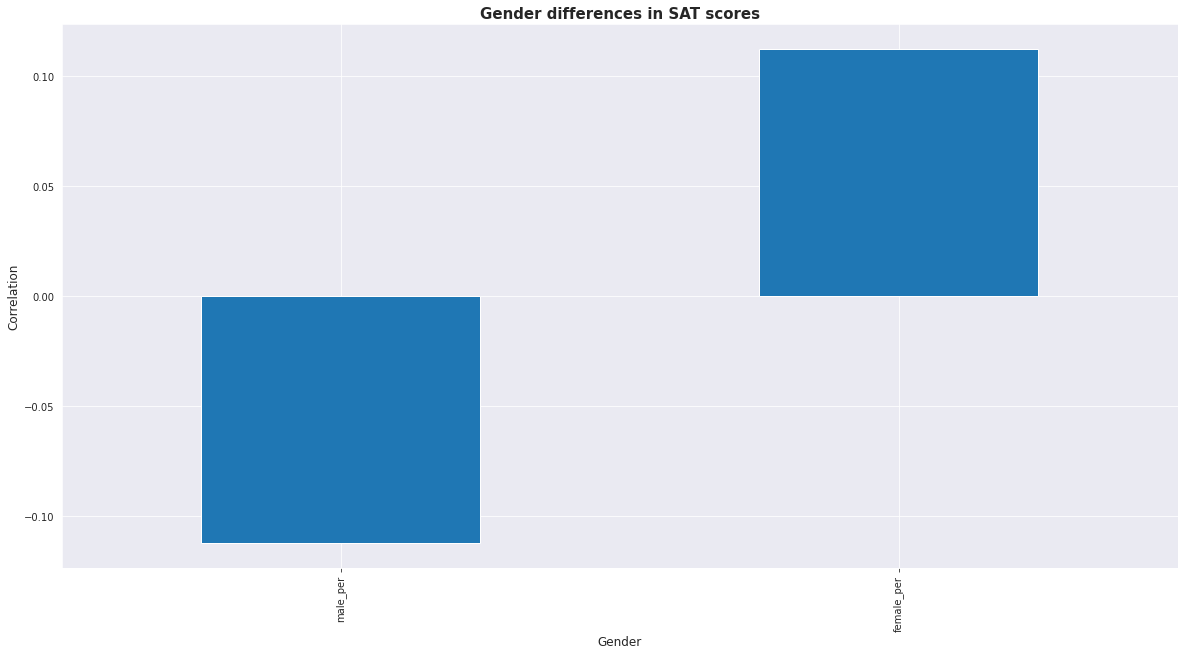

In [101]:
plt.figure(figsize=(20, 10))
ax = correlations[['male_per', 'female_per']].plot.bar()
ax.set_title("Gender differences in SAT scores", fontweight="bold", fontsize=15,)
ax.set_xlabel("Gender",fontsize=12)
ax.set_ylabel("Correlation",fontsize=12)
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)

In the **Gender differences in SAT scores**, we can see that **females** have a high positive correlation with **SAT scores** and **males** a high negative correlation.

## Female gender and SAT score

In [102]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='female_per',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["female_per"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='Female %',
    yTitle='Satisfaction score avg',
    title='Female per vs Sat score'
)

From the scatter above we can see a strong correlation between **Satisfaction Score** and **Female percentage**. But, there is a cluster of schools with a female percentage between 55% and 65% with a **high** SAT score.

In [103]:
combined[(
    combined["female_per"] > 60) & 
    (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The shwon cluster in the scatter plot which schools are listed aboved, are formed by schools with **high academic standards** and specialized on **arts**. <a href="https://en.wikipedia.org/wiki/Bard_High_School_Early_College" > School info example.</a> 

# AP Exam Scores and SAT Scores

In the U.S., high school students take <a href="https://en.wikipedia.org/wiki/Advanced_Placement_exams" > Advanced Placement (AP).</a> exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [104]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

## AP per and SAT score

In [105]:
fig = px.scatter(combined[['sat_score','SCHOOL NAME', 'ap_per', 'boro']].dropna(),
                 trendline='ols',
                 x="ap_per", 
                 y="sat_score", 
                 size="ap_per", 
                 color="sat_score", 
                 size_max=15, 
                 hover_name="SCHOOL NAME", 
                 hover_data=['boro', 'ap_per','sat_score'],
                 color_continuous_scale=px.colors.sequential.Viridis, 
                 title='AP per vs Sat score')
fig.show()


It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though. There are some cases with a high **ap_per** and low **sat_score** and some cases with low **ap_per** and low **sat_score**.

# Average Class Size and SAT score 

In [106]:
combined[['sat_score','SCHOOL NAME','AVERAGE CLASS SIZE', 'boro']]

,sat_score,SCHOOL NAME,AVERAGE CLASS SIZE,boro
0,1122.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,22.564286,Manhattan
1,1172.0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,22.231250,Manhattan
2,1149.0,EAST SIDE COMMUNITY SCHOOL,21.200000,Manhattan
3,1207.0,MARTA VALLE HIGH SCHOOL,23.571429,Manhattan
4,1621.0,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",25.510526,Manhattan
...,...,...,...,...
358,1154.0,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,22.958824,Brooklyn
359,1035.0,BUSHWICK SCHOOL FOR SOCIAL JUSTICE,22.760000,Brooklyn
360,1060.0,ACADEMY OF URBAN PLANNING,23.900000,Brooklyn
361,1315.0,ALL CITY LEADERSHIP SECONDARY SCHOOL,17.793750,Brooklyn


In [107]:
fig = px.scatter(combined[['sat_score','SCHOOL NAME', 'AVERAGE CLASS SIZE', 'boro']].dropna(),
                 trendline='ols',
                 x="AVERAGE CLASS SIZE", 
                 y="sat_score", 
                 size="AVERAGE CLASS SIZE", 
                 color="sat_score", 
                 size_max=15, 
                 hover_name="SCHOOL NAME", 
                 hover_data=['boro', 'AVERAGE CLASS SIZE','sat_score'],
                 color_continuous_scale=px.colors.sequential.Viridis, 
                 title='Average Class Size vs SAT Scores')
fig.show()

From the previous scatter plot we can extract that there is a correlation and in general schools with higher average in terms of class size seem to have also a higher average in SAT scores.

# Schools final scores

In [108]:
combined.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per,final_sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,0.305756,1.186626
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,0.098985,1.292734
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,0.031773,1.263724
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,0.351577,1.303027
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,0.158091,3.397787


In [109]:
combined.describe()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,ap_per,final_sat_score
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,...,363.000000,363.000000,363.000000,363.0,363.0,363.0,363.000000,363.000000,363.000000,363.000000
mean,404.119403,419.656716,399.662687,1223.438806,129.028846,197.038462,153.450000,193.870968,14.019284,171.762429,...,10724.719008,777.556474,1.834711,0.0,0.0,0.0,40.743533,-73.925345,0.210503,1.728054
std,57.486468,64.804541,59.187101,178.223775,175.816044,310.125423,239.117292,224.190938,9.251380,184.956860,...,536.599348,815.206633,1.680307,0.0,0.0,0.0,0.081881,0.071633,0.167423,1.060487
min,279.000000,312.000000,286.000000,887.000000,6.000000,6.000000,6.000000,1.000000,1.000000,10.000000,...,10002.000000,110.000000,1.000000,0.0,0.0,0.0,40.528229,-74.192154,0.011765,0.589832
25%,371.000000,378.000000,365.000000,1113.000000,42.000000,56.000000,76.000000,82.000000,7.000000,80.311189,...,10301.000000,395.000000,1.000000,0.0,0.0,0.0,40.687143,-73.979256,0.069868,1.116121
50%,397.000000,408.000000,390.000000,1193.000000,129.028846,197.038462,153.450000,111.000000,12.000000,105.166667,...,10472.000000,477.000000,1.000000,0.0,0.0,0.0,40.741205,-73.929154,0.172805,1.331321
75%,417.500000,439.000000,411.500000,1266.500000,129.028846,197.038462,153.450000,193.870968,21.000000,153.784188,...,11216.500000,648.000000,2.000000,0.0,0.0,0.0,40.819472,-73.890124,0.307213,1.903177
max,679.000000,735.000000,682.000000,2096.000000,2117.000000,3692.000000,2687.000000,1209.000000,32.000000,1329.052632,...,11694.000000,5458.000000,10.000000,0.0,0.0,0.0,40.888373,-73.726910,0.877747,8.611356


In [110]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
ap_per                             0.057171
final_sat_score                    0.760635
Name: sat_score, Length: 69, dtype: float64

To compute the **Schools Final Score** from the correlations array, all the columns with a positive correlation bigger than the **threshold** (threshold=0.35) will be used.

In [111]:
positivie_correlations = correlations[correlations > 0.35]
positivie_correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
asian_num                               0.475445
asian_per                               0.570730
white_num                               0.449559
white_per                               0.620718
female_num                              0.388631
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
final_sat_score                         0.760635
Name: sat_score, dty

Before that, we will remove the columns that contain repeted information or may affect on the final score, this columns are:
<ul>
    <li><b>asian_num</b></li>
    <li><b>white_num</b></li>    
</ul>


In [112]:
positivie_correlations = positivie_correlations.drop(labels=['asian_num', 'white_num'])

In [113]:
aux = combined[positivie_correlations.index]
aux

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,total_enrollment,asian_per,white_per,female_num,N_s,N_p,total_students,final_sat_score
0,355.0,404.0,363.0,1122.0,129.028846,197.038462,153.45,88.000000,4.000000,22.564286,422,14.0,1.7,163.0,379.000000,151.0,323.0,1.186626
1,383.0,423.0,366.0,1172.0,39.000000,49.000000,10.00,105.687500,4.750000,22.231250,394,29.2,2.3,168.0,385.000000,46.0,299.0,1.292734
2,377.0,402.0,370.0,1149.0,19.000000,21.000000,153.45,57.600000,2.733333,21.200000,598,9.7,10.4,271.0,598.208333,150.0,649.0,1.263724
3,390.0,433.0,384.0,1207.0,129.028846,197.038462,153.45,69.642857,3.000000,23.571429,367,9.3,1.6,197.0,306.000000,69.0,401.0,1.303027
4,522.0,574.0,525.0,1621.0,255.000000,377.000000,191.00,156.368421,6.157895,25.510526,1613,27.8,44.9,819.0,923.000000,736.0,1725.0,3.397787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,384.0,409.0,361.0,1154.0,47.000000,64.000000,13.00,150.941176,6.411765,22.958824,606,1.7,0.7,290.0,504.000000,205.0,513.0,1.258947
359,348.0,353.0,334.0,1035.0,129.028846,197.038462,153.45,71.066667,3.266667,22.760000,434,0.5,1.8,224.0,295.000000,160.0,416.0,0.936425
360,342.0,364.0,354.0,1060.0,76.000000,100.000000,10.00,102.375000,4.312500,23.900000,398,1.5,1.0,181.0,256.000000,127.0,313.0,0.939801
361,428.0,465.0,422.0,1315.0,7.000000,8.000000,153.45,66.937500,3.812500,17.793750,263,5.3,1.5,126.0,206.000000,80.0,333.0,1.258644


In [114]:
aux.describe()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,total_enrollment,asian_per,white_per,female_num,N_s,N_p,total_students,final_sat_score
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,404.119403,419.656716,399.662687,1223.438806,129.028846,197.038462,153.450000,171.762429,6.491468,24.794077,793.035813,10.149587,8.430028,392.983471,598.208333,247.721763,777.556474,1.728054
std,57.486468,64.804541,59.187101,178.223775,175.816044,310.125423,239.117292,184.956860,5.956961,3.555077,865.298394,14.716465,14.030145,426.246744,667.764179,283.769637,815.206633,1.060487
min,279.000000,312.000000,286.000000,887.000000,6.000000,6.000000,6.000000,10.000000,1.000000,10.000000,141.000000,0.000000,0.000000,0.000000,70.000000,12.000000,110.000000,0.589832
25%,371.000000,378.000000,365.000000,1113.000000,42.000000,56.000000,76.000000,80.311189,3.366071,22.642708,386.500000,1.300000,1.000000,183.000000,291.000000,102.000000,395.000000,1.116121
50%,397.000000,408.000000,390.000000,1193.000000,129.028846,197.038462,153.450000,105.166667,4.375000,24.966667,471.000000,3.800000,2.100000,244.000000,374.000000,175.000000,477.000000,1.331321
75%,417.500000,439.000000,411.500000,1266.500000,129.028846,197.038462,153.450000,153.784188,6.296703,27.157222,669.000000,10.750000,8.900000,374.500000,552.500000,279.000000,648.000000,1.903177
max,679.000000,735.000000,682.000000,2096.000000,2117.000000,3692.000000,2687.000000,1329.052632,41.157895,37.023077,5332.000000,89.500000,82.100000,2315.000000,4768.000000,2804.000000,5458.000000,8.611356


Now we have a **dataset** with the most signigicant columns. But as it is shown in the previous description this columns values are in different ranges, that's why we previously importes <a href="https://scikit-learn.org/stable/modules/preprocessing.html">Sklearn preprocessing</a>, now all this dataset values will be scaled to values between **0 and 1**.

In [115]:
x = aux.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [116]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.1900,0.217494,0.194444,0.194376,0.058280,0.051828,0.054998,0.059133,0.074705,0.464947,0.054132,0.156425,0.020706,0.070410,0.065773,0.049785,0.039828,0.074399
1,0.2600,0.262411,0.202020,0.235732,0.015632,0.011666,0.001492,0.072543,0.093381,0.452622,0.048738,0.326257,0.028015,0.072570,0.067050,0.012178,0.035340,0.087627
2,0.2450,0.212766,0.212121,0.216708,0.006158,0.004069,0.054998,0.036087,0.043163,0.414461,0.088037,0.108380,0.126675,0.117063,0.112433,0.049427,0.100785,0.084010
3,0.2775,0.286052,0.247475,0.264682,0.058280,0.051828,0.054998,0.045216,0.049803,0.502216,0.043537,0.103911,0.019488,0.085097,0.050234,0.020415,0.054413,0.088910
4,0.6075,0.619385,0.603535,0.607113,0.117954,0.100651,0.069004,0.110965,0.128440,0.573973,0.283568,0.310615,0.546894,0.353780,0.181567,0.259312,0.301982,0.350053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.2625,0.229314,0.189394,0.220844,0.019422,0.015735,0.002611,0.106850,0.134762,0.479547,0.089578,0.018994,0.008526,0.125270,0.092380,0.069126,0.075355,0.083415
359,0.1725,0.096927,0.121212,0.122415,0.058280,0.051828,0.054998,0.046296,0.056444,0.472189,0.056444,0.005587,0.021924,0.096760,0.047893,0.053009,0.057218,0.043208
360,0.1575,0.122931,0.171717,0.143093,0.033160,0.025502,0.001492,0.070031,0.082487,0.514375,0.049509,0.016760,0.012180,0.078186,0.039591,0.041189,0.037958,0.043629
361,0.3725,0.361702,0.343434,0.354012,0.000474,0.000543,0.054998,0.043165,0.070036,0.288411,0.023502,0.059218,0.018270,0.054428,0.028948,0.024355,0.041698,0.083377


In [117]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,0.312799,0.254508,0.287027,0.278279,0.058280,0.051828,0.054998,0.122635,0.136747,0.547461,0.125609,0.113403,0.102680,0.169755,0.112433,0.084428,0.124824,0.141896
std,0.143716,0.153202,0.149462,0.147414,0.083286,0.084136,0.089190,0.140219,0.148338,0.131557,0.166692,0.164430,0.170891,0.184124,0.142138,0.101637,0.152432,0.132205
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.230000,0.156028,0.199495,0.186931,0.017054,0.013565,0.026110,0.053304,0.058919,0.467849,0.047293,0.014525,0.012180,0.079050,0.047041,0.032235,0.053291,0.065610
50%,0.295000,0.226950,0.262626,0.253102,0.058280,0.051828,0.054998,0.072148,0.084043,0.553848,0.063572,0.042458,0.025579,0.105400,0.064708,0.058381,0.068624,0.092437
75%,0.346250,0.300236,0.316919,0.313896,0.058280,0.051828,0.054998,0.109006,0.131897,0.634910,0.101715,0.120112,0.108404,0.161771,0.102703,0.095630,0.100598,0.163728
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
df['final_sat_score'] = df.sum(axis=1)
df['final_sat_score'] = (df['final_sat_score'] * 10) / 17
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,final_sat_score
0,0.1900,0.217494,0.194444,0.194376,0.058280,0.051828,0.054998,0.059133,0.074705,0.464947,0.054132,0.156425,0.020706,0.070410,0.065773,0.049785,0.039828,0.074399,1.230390
1,0.2600,0.262411,0.202020,0.235732,0.015632,0.011666,0.001492,0.072543,0.093381,0.452622,0.048738,0.326257,0.028015,0.072570,0.067050,0.012178,0.035340,0.087627,1.344279
2,0.2450,0.212766,0.212121,0.216708,0.006158,0.004069,0.054998,0.036087,0.043163,0.414461,0.088037,0.108380,0.126675,0.117063,0.112433,0.049427,0.100785,0.084010,1.313142
3,0.2775,0.286052,0.247475,0.264682,0.058280,0.051828,0.054998,0.045216,0.049803,0.502216,0.043537,0.103911,0.019488,0.085097,0.050234,0.020415,0.054413,0.088910,1.355327
4,0.6075,0.619385,0.603535,0.607113,0.117954,0.100651,0.069004,0.110965,0.128440,0.573973,0.283568,0.310615,0.546894,0.353780,0.181567,0.259312,0.301982,0.350053,3.603701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.2625,0.229314,0.189394,0.220844,0.019422,0.015735,0.002611,0.106850,0.134762,0.479547,0.089578,0.018994,0.008526,0.125270,0.092380,0.069126,0.075355,0.083415,1.308014
359,0.1725,0.096927,0.121212,0.122415,0.058280,0.051828,0.054998,0.046296,0.056444,0.472189,0.056444,0.005587,0.021924,0.096760,0.047893,0.053009,0.057218,0.043208,0.961842
360,0.1575,0.122931,0.171717,0.143093,0.033160,0.025502,0.001492,0.070031,0.082487,0.514375,0.049509,0.016760,0.012180,0.078186,0.039591,0.041189,0.037958,0.043629,0.965465
361,0.3725,0.361702,0.343434,0.354012,0.000474,0.000543,0.054998,0.043165,0.070036,0.288411,0.023502,0.059218,0.018270,0.054428,0.028948,0.024355,0.041698,0.083377,1.307689


In [119]:
df['final_sat_score'].describe()

count    363.000000
mean       1.811522
std        1.138255
min        0.589832
25%        1.154715
50%        1.385696
75%        1.999487
max        9.199592
Name: final_sat_score, dtype: float64

Now let's add the **final_sat_score** column to the previous **combined** dataframe.

In [120]:
combined['final_sat_score'] = df['final_sat_score']
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per,final_sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,0.305756,1.230390
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,0.098985,1.344279
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,0.031773,1.313142
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,0.351577,1.355327
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,0.158091,3.603701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,32K545,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,88,384.0,409.0,361.0,1154.0,EBC-HS FOR PUB SERVICE (BUSH),47.000000,64.000000,...,0,0.0,0.0,0.0,"1155 Dekalb Avenue\nBrooklyn, NY 11221\n(40.69...",40.694482,-73.929154,32,0.077558,1.308014
359,32K549,BUSHWICK SCHOOL FOR SOCIAL JUSTICE,75,348.0,353.0,334.0,1035.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32,0.297301,0.961842
360,32K552,ACADEMY OF URBAN PLANNING,67,342.0,364.0,354.0,1060.0,Academy of Urban Planning,76.000000,100.000000,...,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32,0.190955,0.965465
361,32K554,ALL CITY LEADERSHIP SECONDARY SCHOOL,39,428.0,465.0,422.0,1315.0,All City Leadership Secondary School,7.000000,8.000000,...,Then to New York City residents,0.0,0.0,0.0,"321 Palmetto Street\nBrooklyn, NY 11237\n(40.6...",40.697408,-73.913153,32,0.026616,1.307689


In [121]:
combined.loc[combined['final_sat_score'] > 5]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per,final_sat_score
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02,0.457992,7.821063
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.0,1236.0,...,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03,0.265259,5.439975
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10,0.394955,7.055040
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13,0.397037,9.199592
270,21K525,EDWARD R. MURROW HIGH SCHOOL,727,468.0,496.0,467.0,1431.0,EDWARD R MURROW HS,397.0,577.0,...,0,0.0,0.0,0.0,"1600 Avenue L\nBrooklyn, NY 11230\n(40.6205043...",40.620504,-73.959234,21,0.098707,5.309023
276,22K405,MIDWOOD HIGH SCHOOL,824,478.0,519.0,476.0,1473.0,MIDWOOD HS,745.0,1223.0,...,0,0.0,0.0,0.0,"2839 Bedford Avenue\nBrooklyn, NY 11210\n(40.6...",40.633335,-73.952916,22,0.193909,6.094647
304,26Q415,BENJAMIN N. CARDOZO HIGH SCHOOL,888,480.0,545.0,489.0,1514.0,BENJAMIN N. CARDOZO,676.0,1145.0,...,0,0.0,0.0,0.0,"57-00 223Rd Street\nOakland Gardens, NY 11364\...",40.752392,-73.756083,26,0.172802,5.781923
305,26Q430,FRANCIS LEWIS HIGH SCHOOL,934,468.0,539.0,467.0,1474.0,FRANCIS LEWIS HS,697.0,1033.0,...,0,0.0,0.0,0.0,"58-20 Utopia Parkway\nFresh Meadows, NY 11365\...",40.740556,-73.792848,26,0.167871,5.332320
322,28Q440,FOREST HILLS HIGH SCHOOL,762,456.0,497.0,454.0,1407.0,FOREST HILLS HS,733.0,1116.0,...,0,0.0,0.0,0.0,"67-01 110 Street\nForest Hills, NY 11375\n(40....",40.729432,-73.845629,28,0.191184,5.346358
353,31R455,TOTTENVILLE HIGH SCHOOL,807,462.0,486.0,470.0,1418.0,TOTTENVILLE HS,396.0,687.0,...,0,0.0,0.0,0.0,"100 Luten Avenue\nStaten Island, NY 10312\n(40...",40.528229,-74.192154,31,0.102194,5.210806


In [122]:
combined.loc[combined['final_sat_score'].idxmax()]

DBN                                                        13K430
SCHOOL NAME                        BROOKLYN TECHNICAL HIGH SCHOOL
Num of SAT Test Takers                                       1277
SAT Critical Reading Avg. Score                               587
SAT Math Avg. Score                                           659
                                                ...              
lat                                                       40.6881
lon                                                      -73.9767
school_dist                                                    13
ap_per                                                   0.397037
final_sat_score                                           9.19959
Name: 187, Length: 162, dtype: object

As we can see following our sclae, only **8** schools have a final sat score bigger than 5. The school with the best final sat score is **BROOKLYN TECHNICAL HIGH SCHOOL**. The next chart shows all the **final sat score** results for each school. 

In [123]:
fig = px.bar(combined, x='SCHOOL NAME', y='final_sat_score', title='Final sat score by school')
fig.show()

# Conclusions